## Đọc dữ liệu gốc và tiền xử lý

In [1]:
#Tải dữ liệu
import pandas as pd
df = pd.read_csv('gold_with_cpi.csv')
df_clean = df.copy()

In [2]:
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean.sort_values('Date', inplace=True)

In [3]:
# Xử lý các cột giá trị số có dấu phẩy: Price, Open, High, Low
cols_to_convert = ['Price', 'Open', 'High', 'Low']
for col in cols_to_convert:
    df_clean[col] = df_clean[col].str.replace(',', '').astype(float)

In [4]:
# Xử lý cột 'Change %' - loại bỏ ký tự '%' và chuyển sang float
df_clean['Change %'] = df_clean['Change %'].str.replace('%', '').astype(float)

In [5]:
# Hàm chuyển đổi cột 'Vol.' sang số thực
def convert_volume(val):
    if isinstance(val, str):
        val = val.strip()
        if val.endswith('K'):
            return float(val[:-1].replace(',', '')) * 1e3
        elif val.endswith('M'):
            return float(val[:-1].replace(',', '')) * 1e6
        else:
            return float(val.replace(',', ''))
    return None

#chuyển đổi cột 'Vol.' sang số thực
df_clean['Vol.'] = df_clean['Vol.'].apply(convert_volume)

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3886 entries, 3885 to 0
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3886 non-null   datetime64[ns]
 1   Price     3886 non-null   float64       
 2   Open      3886 non-null   float64       
 3   High      3886 non-null   float64       
 4   Low       3886 non-null   float64       
 5   Vol.      3883 non-null   float64       
 6   Change %  3886 non-null   float64       
 7   CPIAUCSL  3886 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 273.2 KB


In [7]:
df_clean.head()

,Date,Price,Open,High,Low,Vol.,Change %,CPIAUCSL
3885,2010-01-04,1118.3,1099.0,1124.6,1093.8,155480.0,2.02,217.488
3884,2010-01-05,1118.7,1122.0,1129.6,1115.5,156410.0,0.04,217.488
3883,2010-01-06,1136.5,1118.5,1141.0,1116.8,176900.0,1.59,217.488
3882,2010-01-07,1133.7,1139.0,1139.5,1128.7,121150.0,-0.25,217.488
3881,2010-01-08,1138.9,1131.5,1140.0,1119.5,212620.0,0.46,217.488


In [8]:
#Số dòng và cột
df_clean.shape

(3886, 8)

In [9]:
# Mô tả thống kê cho các cột số
df_clean.describe()

,Date,Price,Open,High,Low,Vol.,Change %,CPIAUCSL
count,3886,3886.000000,3886.000000,3886.000000,3886.000000,3883.000000,3886.000000,3886.000000
mean,2017-08-30 12:35:34.431291648,1569.778513,1569.838767,1580.882167,1558.222118,136609.881535,0.032136,255.422286
min,2010-01-04 00:00:00,1049.600000,1051.500000,1062.700000,1044.500000,120.000000,-9.340000,217.199000
25%,2013-11-07 06:00:00,1265.000000,1265.300000,1273.300000,1257.175000,4695.000000,-0.440000,234.100000
50%,2017-09-13 12:00:00,1472.000000,1471.900000,1478.800000,1461.100000,141480.000000,0.030000,246.435000
75%,2021-06-21 18:00:00,1798.500000,1798.675000,1811.575000,1785.375000,202805.000000,0.570000,270.710000
max,2025-04-01 00:00:00,3150.300000,3157.300000,3177.000000,3130.500000,816530.000000,5.950000,319.775000
std,NaN,388.109086,387.812065,390.855496,384.978763,112053.824866,0.998387,29.344785


### Xử lý dữ liệu bị thiếu

In [10]:
#Tìm giá trị bị thiếu
import numpy as np
features_na = [features for features in df_clean.columns if df_clean[features].isnull().sum() > 0]
if features_na:
    for feature in features_na:
        print(f"{feature}: {np.round(df_clean[feature].isnull().mean()*100, 2)}% missing values")
else:
    print("No missing value found")

Vol.: 0.08% missing values


In [11]:
# Điền giá trị thiếu trong cột 'Vol.' bằng giá trị trung bình
df_clean['Vol.'] = df_clean['Vol.'].fillna(df_clean['Vol.'].mean())

# Xác nhận lại không còn missing values
df_clean.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
CPIAUCSL    0
dtype: int64

## Bổ sung ngày bị thiếu (các ngày thứ 7, chủ nhật, ngày lễ)

In [12]:
#  Đặt 'Date' làm index và sắp xếp
df_time = df_clean.set_index('Date').sort_index()

In [13]:
#  Tạo lịch ngày đầy đủ từ ngày đầu đến ngày cuối
full_range = pd.date_range(start=df_time.index.min(), end=df_time.index.max(), freq='D')

In [14]:
#  Reindex để chèn các ngày bị thiếu (như cuối tuần, lễ)
df_full = df_time.reindex(full_range)
df_full.index.name = 'Date'  # đặt lại tên index nếu cần

In [16]:
# Xử lý CPIAUCSL: điền theo giá trị đầu tháng
df_full_interpolated = df_full.copy()
df_full_interpolated['Month'] = df_full_interpolated.index.to_period('M')
monthly_cpi = df_full_interpolated['CPIAUCSL'].groupby(df_full_interpolated['Month']).transform('first')
df_full_interpolated['CPIAUCSL'] = monthly_cpi
df_full_interpolated.drop(columns='Month', inplace=True)

In [18]:
# Nội suy các cột còn lại (trừ CPIAUCSL)
columns_to_interpolate = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
df_full_interpolated[columns_to_interpolate] = df_full_interpolated[columns_to_interpolate].interpolate(method='linear')
# Kiểm tra lại giá trị thiếu (nếu còn)
print(df_full_interpolated.isnull().sum())

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
CPIAUCSL    0
dtype: int64


In [20]:
# Tập ngày ban đầu
original_dates = set(df_clean['Date'])

# Lịch ngày đầy đủ
full_dates = set(pd.date_range(start=df_clean['Date'].min(), end=df_clean['Date'].max(), freq='D'))

# Ngày bị thiếu (ngày không giao dịch)
missing_dates = sorted(full_dates - original_dates)

print(f"Số ngày không có giao dịch: {len(missing_dates)}")
print("Ví dụ một vài ngày không giao dịch:")
print(missing_dates[:10])  # In 10 ngày đầu

missing_df = df_full_interpolated.loc[missing_dates]

print("Giá trị đã được nội suy cho những ngày không có giao dịch:")
print(missing_df.head(10))  # In ra 10 dòng đầu tiên


Số ngày không có giao dịch: 1681
Ví dụ một vài ngày không giao dịch:
[Timestamp('2010-01-09 00:00:00'), Timestamp('2010-01-10 00:00:00'), Timestamp('2010-01-16 00:00:00'), Timestamp('2010-01-17 00:00:00'), Timestamp('2010-01-19 00:00:00'), Timestamp('2010-01-23 00:00:00'), Timestamp('2010-01-24 00:00:00'), Timestamp('2010-01-30 00:00:00'), Timestamp('2010-01-31 00:00:00'), Timestamp('2010-02-06 00:00:00')]
Giá trị đã được nội suy cho những ngày không có giao dịch:
                  Price         Open         High          Low           Vol.  \
Date                                                                            
2010-01-09  1143.066667  1134.000000  1147.666667  1126.000000  199670.000000   
2010-01-10  1147.233333  1136.500000  1155.333333  1132.500000  186720.000000   
2010-01-16  1133.666667  1138.233333  1144.233333  1126.833333  159143.333333   
2010-01-17  1136.833333  1134.466667  1142.466667  1127.166667  173586.666667   
2010-01-19  1126.300000  1134.600000  1141.20

In [21]:
# Thống kê số ngày bị thiếu theo năm
missing_years = pd.Series(missing_dates).dt.year.value_counts().sort_index()
print("Số ngày không giao dịch theo từng năm:")
print(missing_years)
# Thống kê theo tháng
missing_months = pd.Series(missing_dates).dt.to_period('M').value_counts().sort_index()
print("Số ngày không giao dịch theo từng tháng:")
print(missing_months)  

Số ngày không giao dịch theo từng năm:
2010    110
2011    113
2012    114
2013    113
2014    113
2015    113
2016    114
2017    110
2018    107
2019    107
2020    107
2021    107
2022    107
2023    108
2024    109
2025     29
Name: count, dtype: int64
Số ngày không giao dịch theo từng tháng:
2010-01     9
2010-02     9
2010-03     8
2010-04     9
2010-05    10
           ..
2024-11    10
2024-12    10
2025-01    10
2025-02     9
2025-03    10
Freq: M, Name: count, Length: 183, dtype: int64


## EDA

 Kiểm tra các cột trong df_clean có chỉ 1 giá trị duy nhất để có thể bỏ

In [22]:

single_value_columns = [col for col in df_full_interpolated.columns if df_full_interpolated[col].nunique() == 1]

single_value_columns

[]

### Tìm các biến số học trong df_clean

In [23]:

numerical_features = [
    feature for feature in df_full_interpolated.columns 
    if (df_full_interpolated[feature].dtypes != 'O') and (feature not in ['Price'])  #  'Price' là target nên có thể loại ra
]

print('Các biến số học: ', len(numerical_features))
df_full_interpolated[numerical_features].head()


Các biến số học:  6


,Open,High,Low,Vol.,Change %,CPIAUCSL
Date,,,,,,
2010-01-04,1099.0,1124.6,1093.8,155480.0,2.02,217.488
2010-01-05,1122.0,1129.6,1115.5,156410.0,0.04,217.488
2010-01-06,1118.5,1141.0,1116.8,176900.0,1.59,217.488
2010-01-07,1139.0,1139.5,1128.7,121150.0,-0.25,217.488
2010-01-08,1131.5,1140.0,1119.5,212620.0,0.46,217.488


Tìm các biến rời rạc (ít hơn 25 giá trị duy nhất)

In [24]:
discrete_feature = [feature for feature in numerical_features if df_full_interpolated[feature].nunique() < 25]
# In kết quả
len_discrete = len(discrete_feature)
discrete_feature, len_discrete

([], 0)

### Tìm các biến liên tục

In [25]:
numerical_features = [
    feature for feature in df_full_interpolated.columns
    if df_full_interpolated[feature].dtype != 'O' and feature != 'Price'  # giả định 'Price' là target
]

continuous_features = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ['GOD']
]
# In số lượng
len_continuous = len(continuous_features)
continuous_features, len_continuous

(['Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL'], 6)

### Vẽ biểu đồ phân phối cho từng biến liên tục

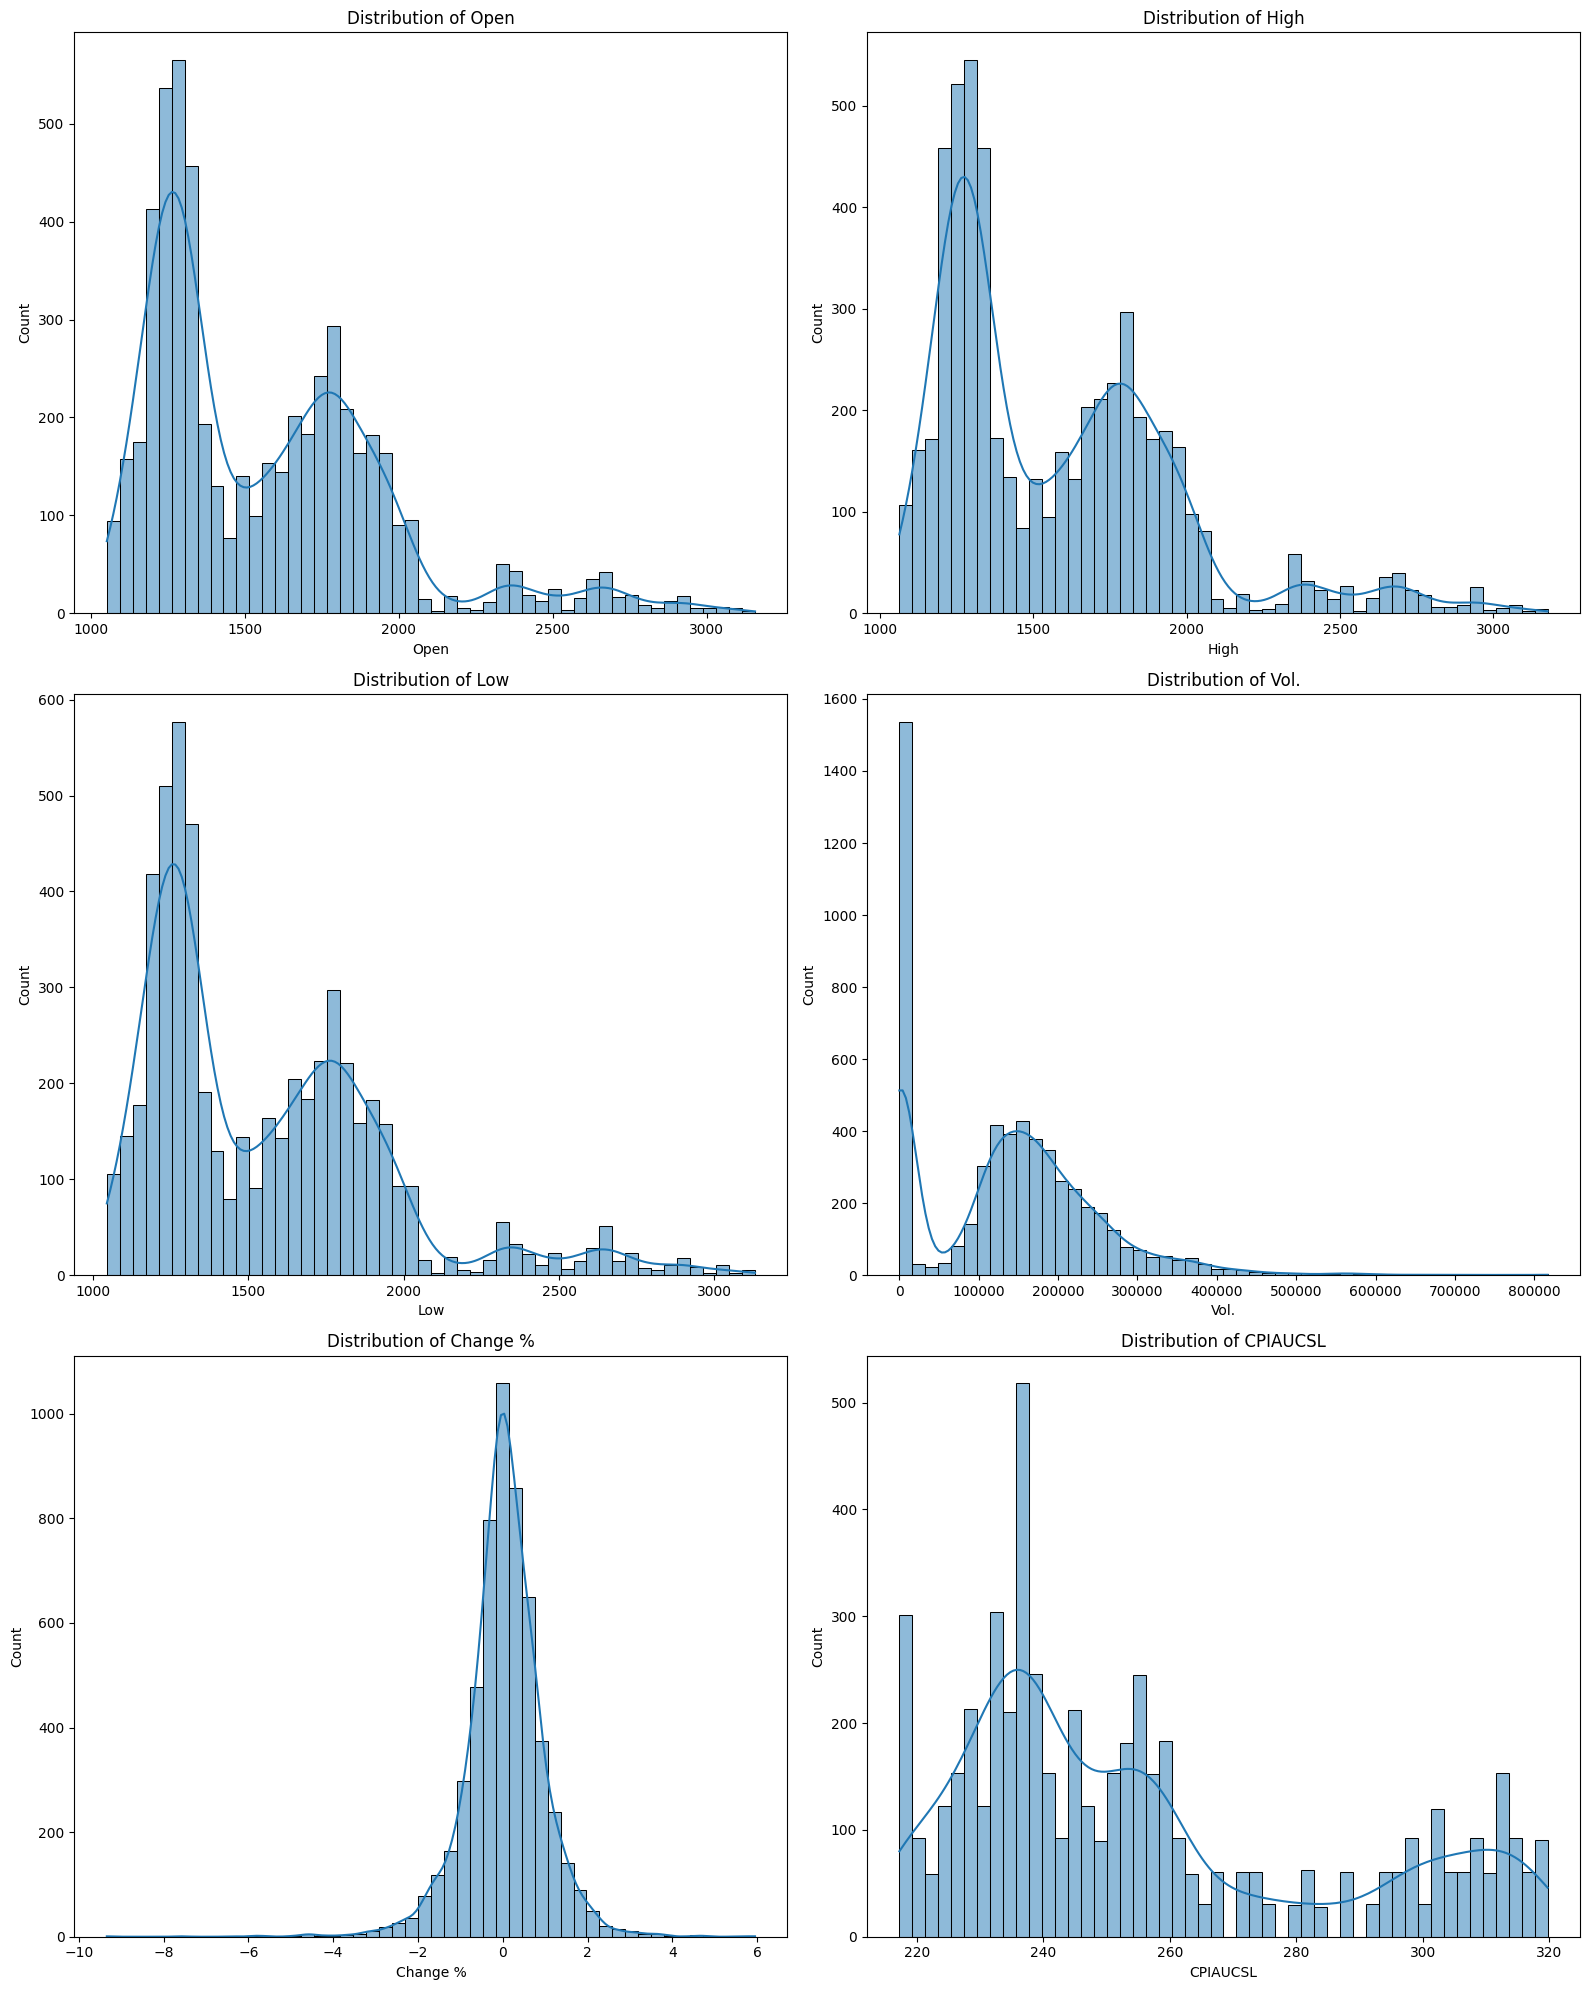

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

continuous_features = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']

plt.figure(figsize=(16, 20), facecolor='white')
plotnumber = 1

for feature in continuous_features:
    ax = plt.subplot(3, 2, plotnumber)
    sns.histplot(df_full_interpolated[feature], kde=True, bins=50)
    plt.xlabel(feature)
    plt.title(f'Distribution of {feature}')
    plotnumber += 1

plt.tight_layout()
plt.show()


- Các biến giá (Open, High, Low) có phân phối gần giống chuẩn nhưng hơi lệch phải (right-skewed).
- Vol. thường phân phối lệch phải mạnh — khá phổ biến với khối lượng giao dịch.
- Change % có dạng đối xứng hơn, gần chuẩn.
- CPIAUCSL tăng dần theo thời gian, nên phân phối có thể lệch mạnh về một phía

### Mối quan hệ giữa các biến liên tục và biến mục tiêu Price

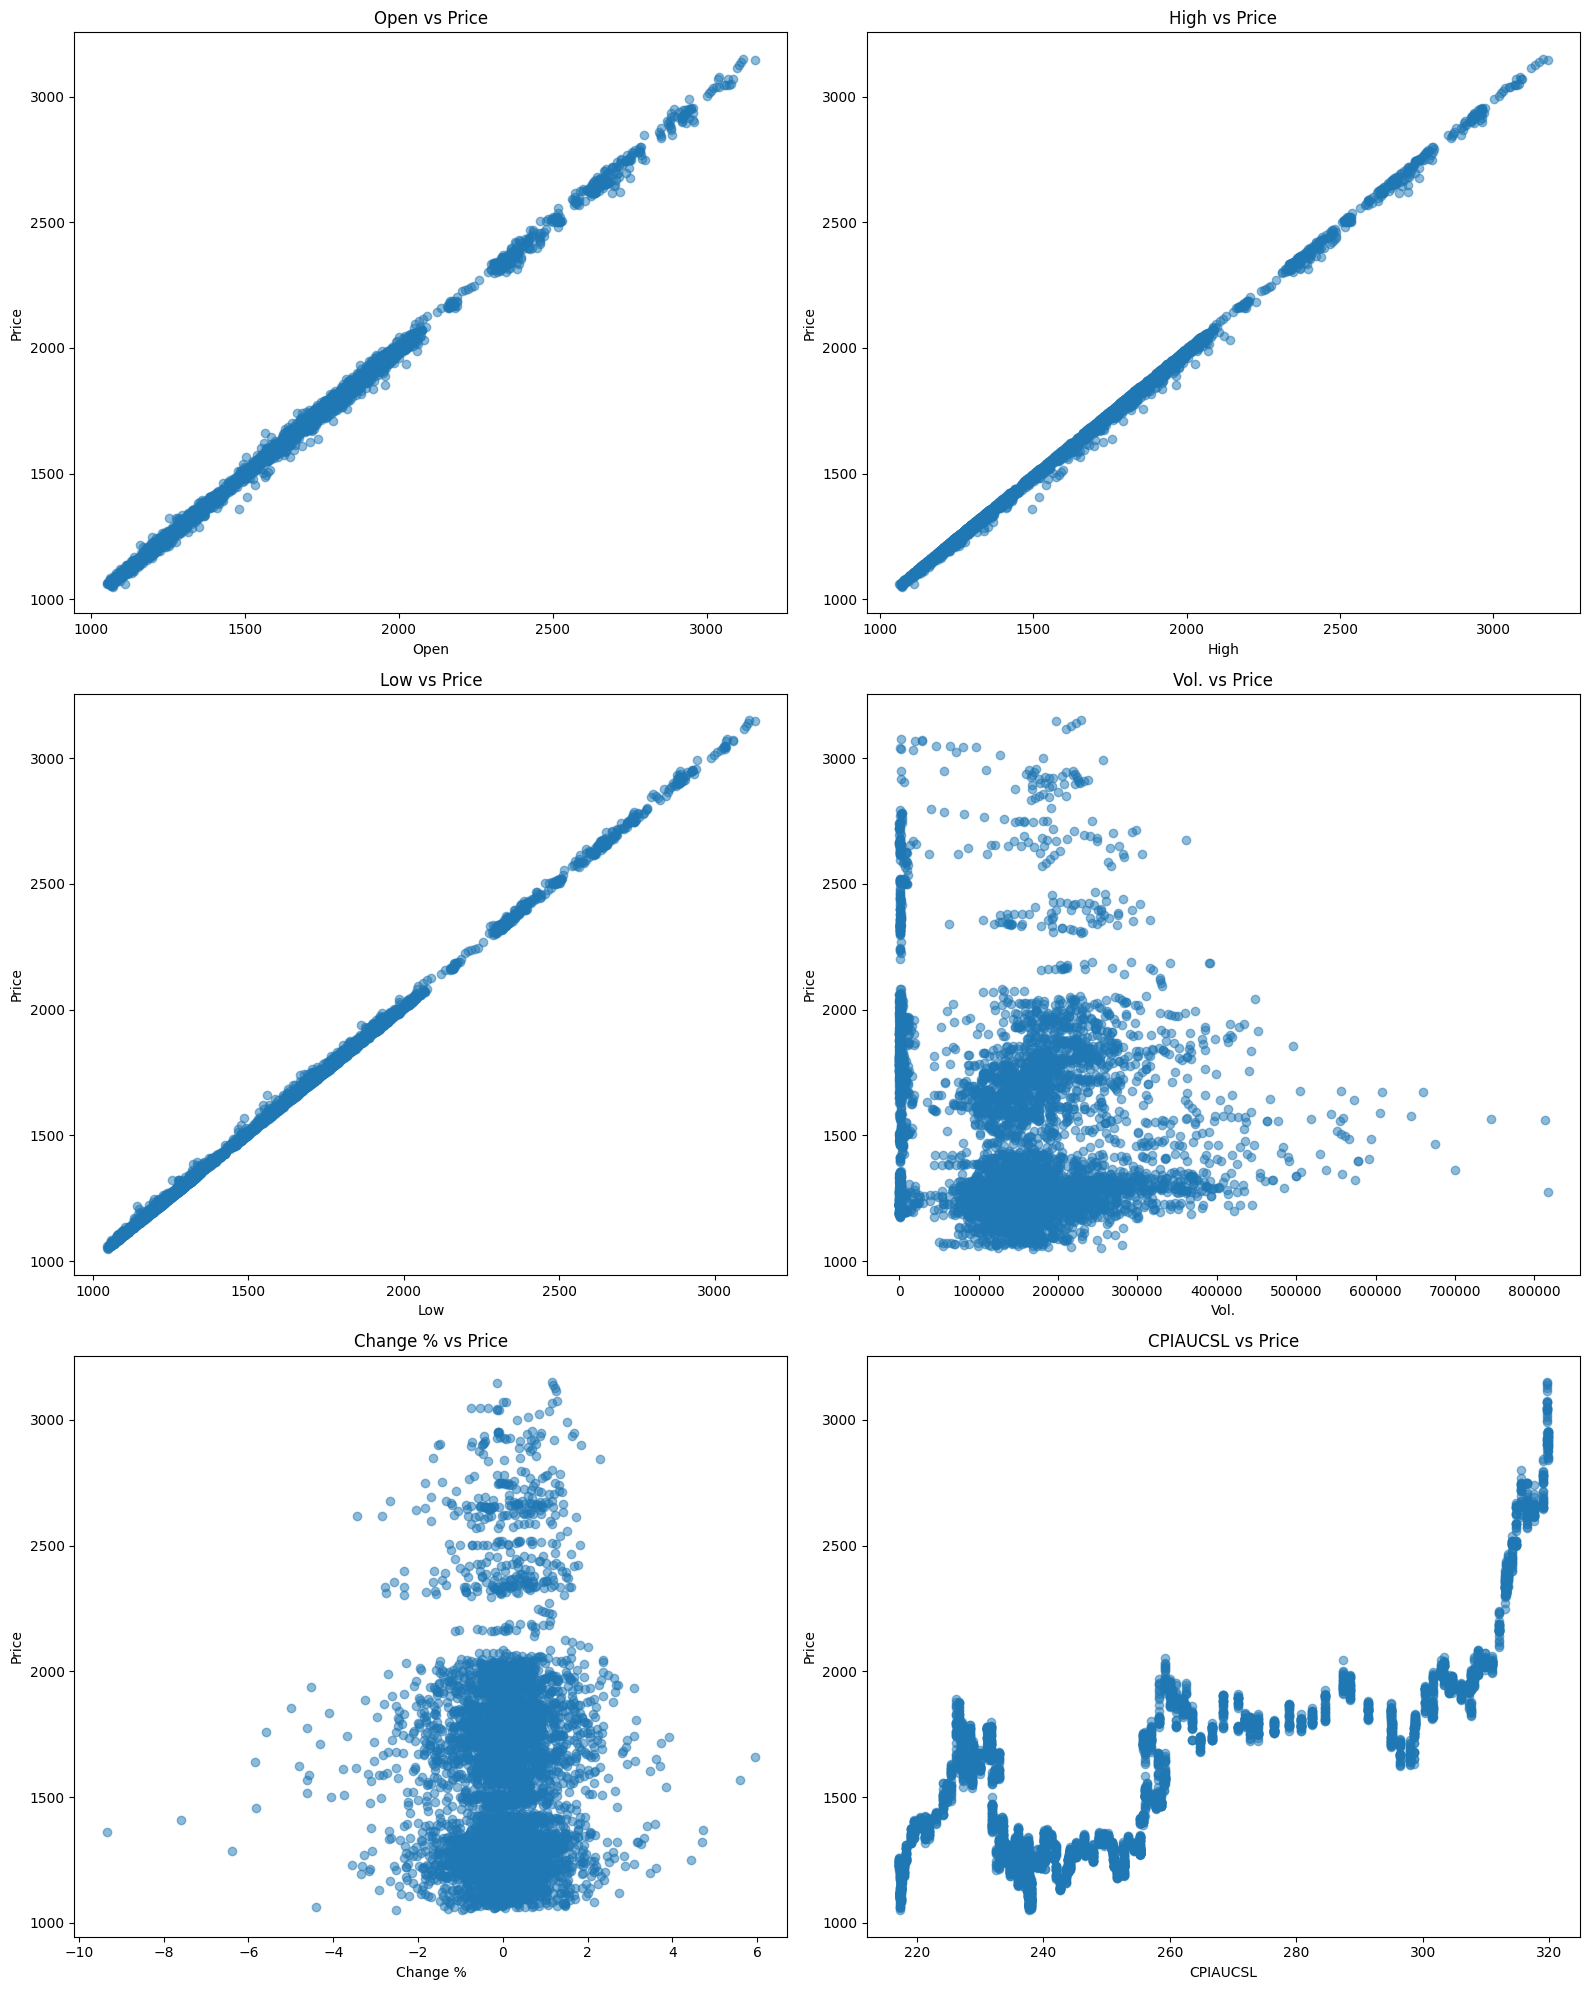

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 20), facecolor='white')
plotnumber = 1

for feature in continuous_features:
    ax = plt.subplot(3, 2, plotnumber)
    plt.scatter(df_full_interpolated[feature], df_full_interpolated['Price'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.title(f'{feature} vs Price')
    plotnumber += 1

plt.tight_layout()
plt.show()


### Kiểm tra outliers trong các biến số học

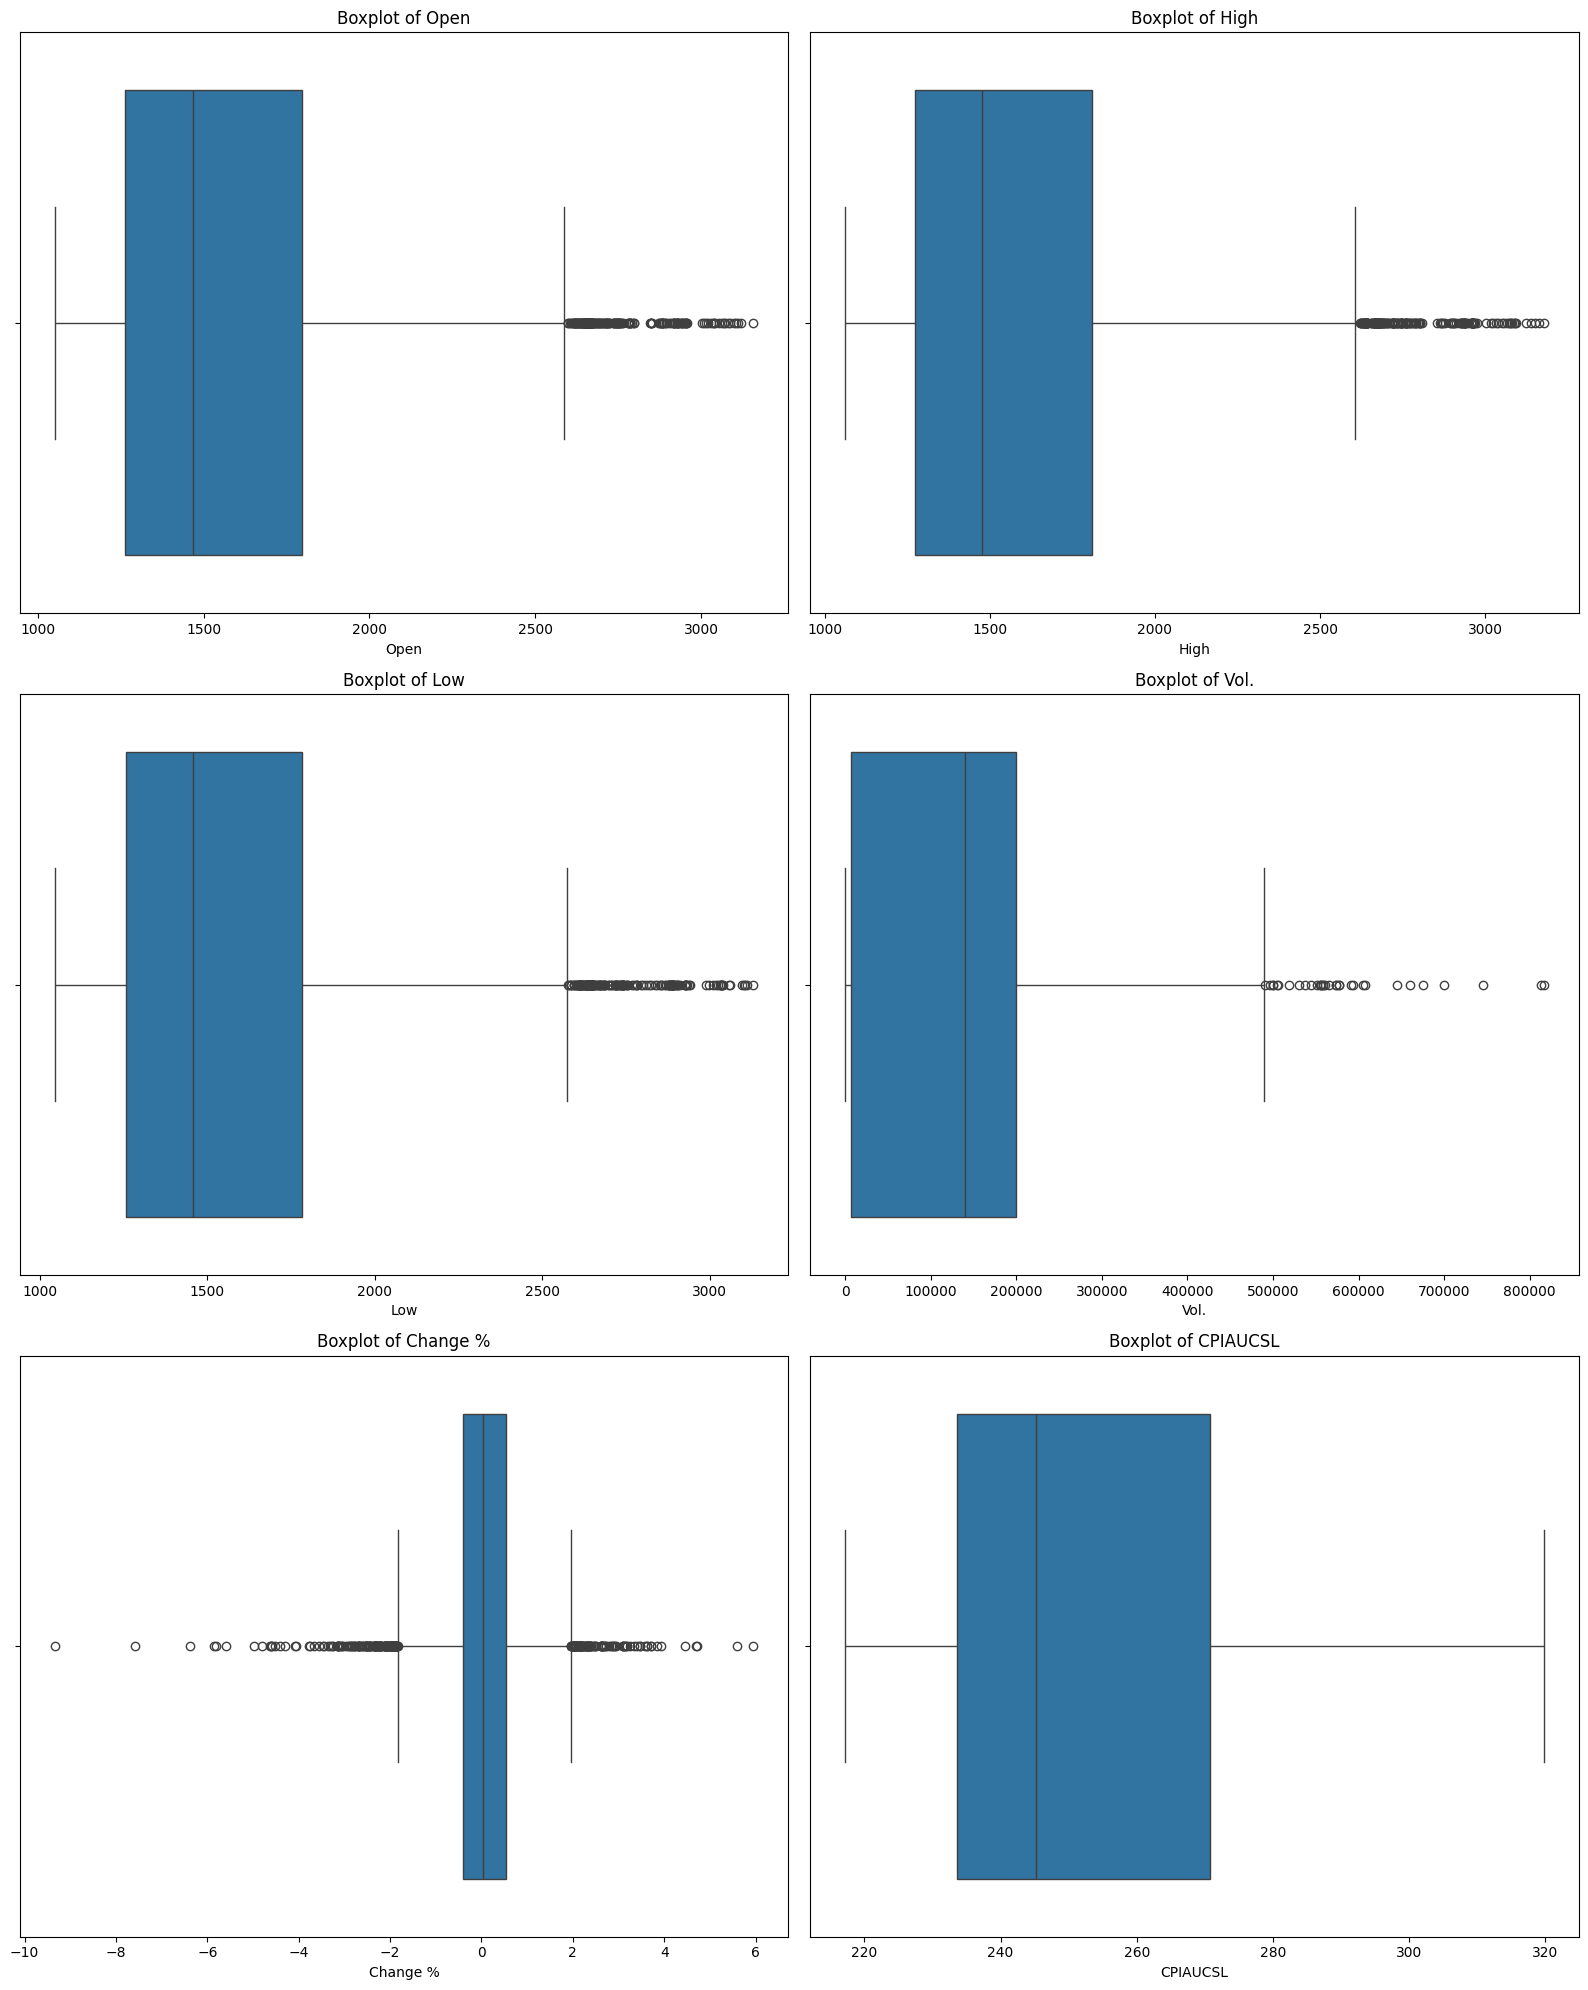

In [28]:
plt.figure(figsize=(16, 20), facecolor='white')
plotnumber = 1

numerical_features = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']

for feature in numerical_features:
    ax = plt.subplot(3, 2, plotnumber)
    sns.boxplot(x=df_full_interpolated[feature])
    plt.xlabel(feature)
    plt.title(f'Boxplot of {feature}')
    plotnumber += 1

plt.tight_layout()
plt.show()


- Vol. và Change % rõ ràng có nhiều outliers (điểm xa khỏi phần thân hộp) — điều này phổ biến với dữ liệu tài chính, đặc biệt là khi có các ngày biến động mạnh.
- Các biến giá (Open, High, Low) có phân phối tương đối ổn định, chỉ vài outliers nhẹ.
- CPIAUCSL rất mượt, không có outlier rõ rệt do nó là chỉ số kinh tế vĩ mô tăng đều.

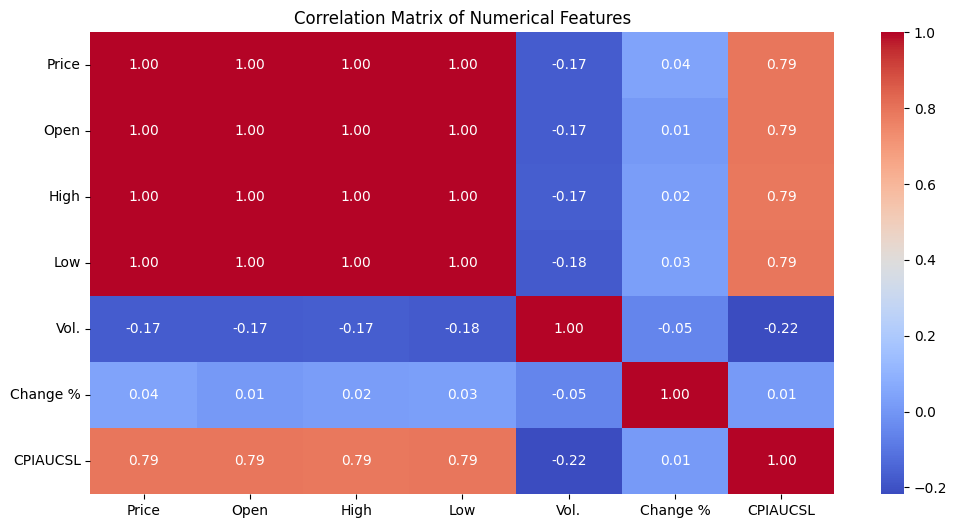

In [29]:
# Tính ma trận tương quan 
cor_mat = df_full_interpolated[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']].corr()

# Vẽ heatmap tương quan
plt.figure(figsize=(12, 6))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


- Price có tương quan rất mạnh với Open, High, Low (gần 1.00) → điều hiển nhiên vì chúng cùng đến từ một chuỗi giá giao dịch.
- Vol. và Change % có tương quan yếu với Price, cho thấy chúng có thể góp phần dự đoán nhưng không tuyến tính rõ rệt.
- CPIAUCSL có tương quan dương nhẹ với Price → có thể là dấu hiệu mối quan hệ kinh tế dài hạn.

### Sắp xếp hệ số tương quan của tất cả các biến với Price, từ cao đến thấp

In [30]:
print(cor_mat['Price'].sort_values(ascending=False), '\n')

Price       1.000000
Low         0.999739
High        0.999644
Open        0.999313
CPIAUCSL    0.790862
Change %    0.040896
Vol.       -0.174308
Name: Price, dtype: float64 

